# 1. Introuction

This notebook outlines the creation, compilation, and training of a ConvNeXt CNN network to classify 101 types of food.

# 2. Importing Libraries

In [4]:
import os
import torch
import torchvision
import torch.backends.cudnn as cudnn
import numpy as np
import pandas as pd

from torch import nn
from torchvision.transforms import v2
from torchinfo import summary
from pathlib import Path
from torchvision import datasets
from torch.optim.lr_scheduler import CosineAnnealingLR
#from warmup_scheduler_pytorch import WarmUpScheduler
#from timm.scheduler.cosine_lr import CosineLRScheduler

# Import custom libraries
from modules.helper_functions import set_seeds, display_random_images
from modules.engine import Trainer, sec_to_min_sec
from modules.scheduler import FixedLRSchedulerWrapper
from modules.dataloaders import create_dataloaders
#from modules.scheduler import WarmupCosineAnnealingLR

# Define some constants
NUM_WORKERS = os.cpu_count()
AMOUNT_TO_GET = 1.0
SEED = 42

# Define target data directory
TARGET_DIR_NAME = f"../data/food-101_{str(int(AMOUNT_TO_GET*100))}_percent"

# Setup training and test directories
TARGET_DIR = Path(TARGET_DIR_NAME)
TRAIN_DIR = TARGET_DIR / "train"
TEST_DIR = TARGET_DIR / "test"
TARGET_DIR.mkdir(parents=True, exist_ok=True)

# Create target model directory
MODEL_DIR = Path("../models")

# Set seeds
set_seeds(SEED)

# 3. Specifying Target Device

In [5]:
# Activate cuda benchmark
cudnn.benchmark = True

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

if device == "cuda":
    !nvidia-smi

Device: cuda
Sun Jan 19 10:11:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   53C    P8             11W /  200W |    1482MiB /  12282MiB |      1%      Default |
|                                         |                        |                  N/A |
+----------------------------------

# 4. Image Visualization

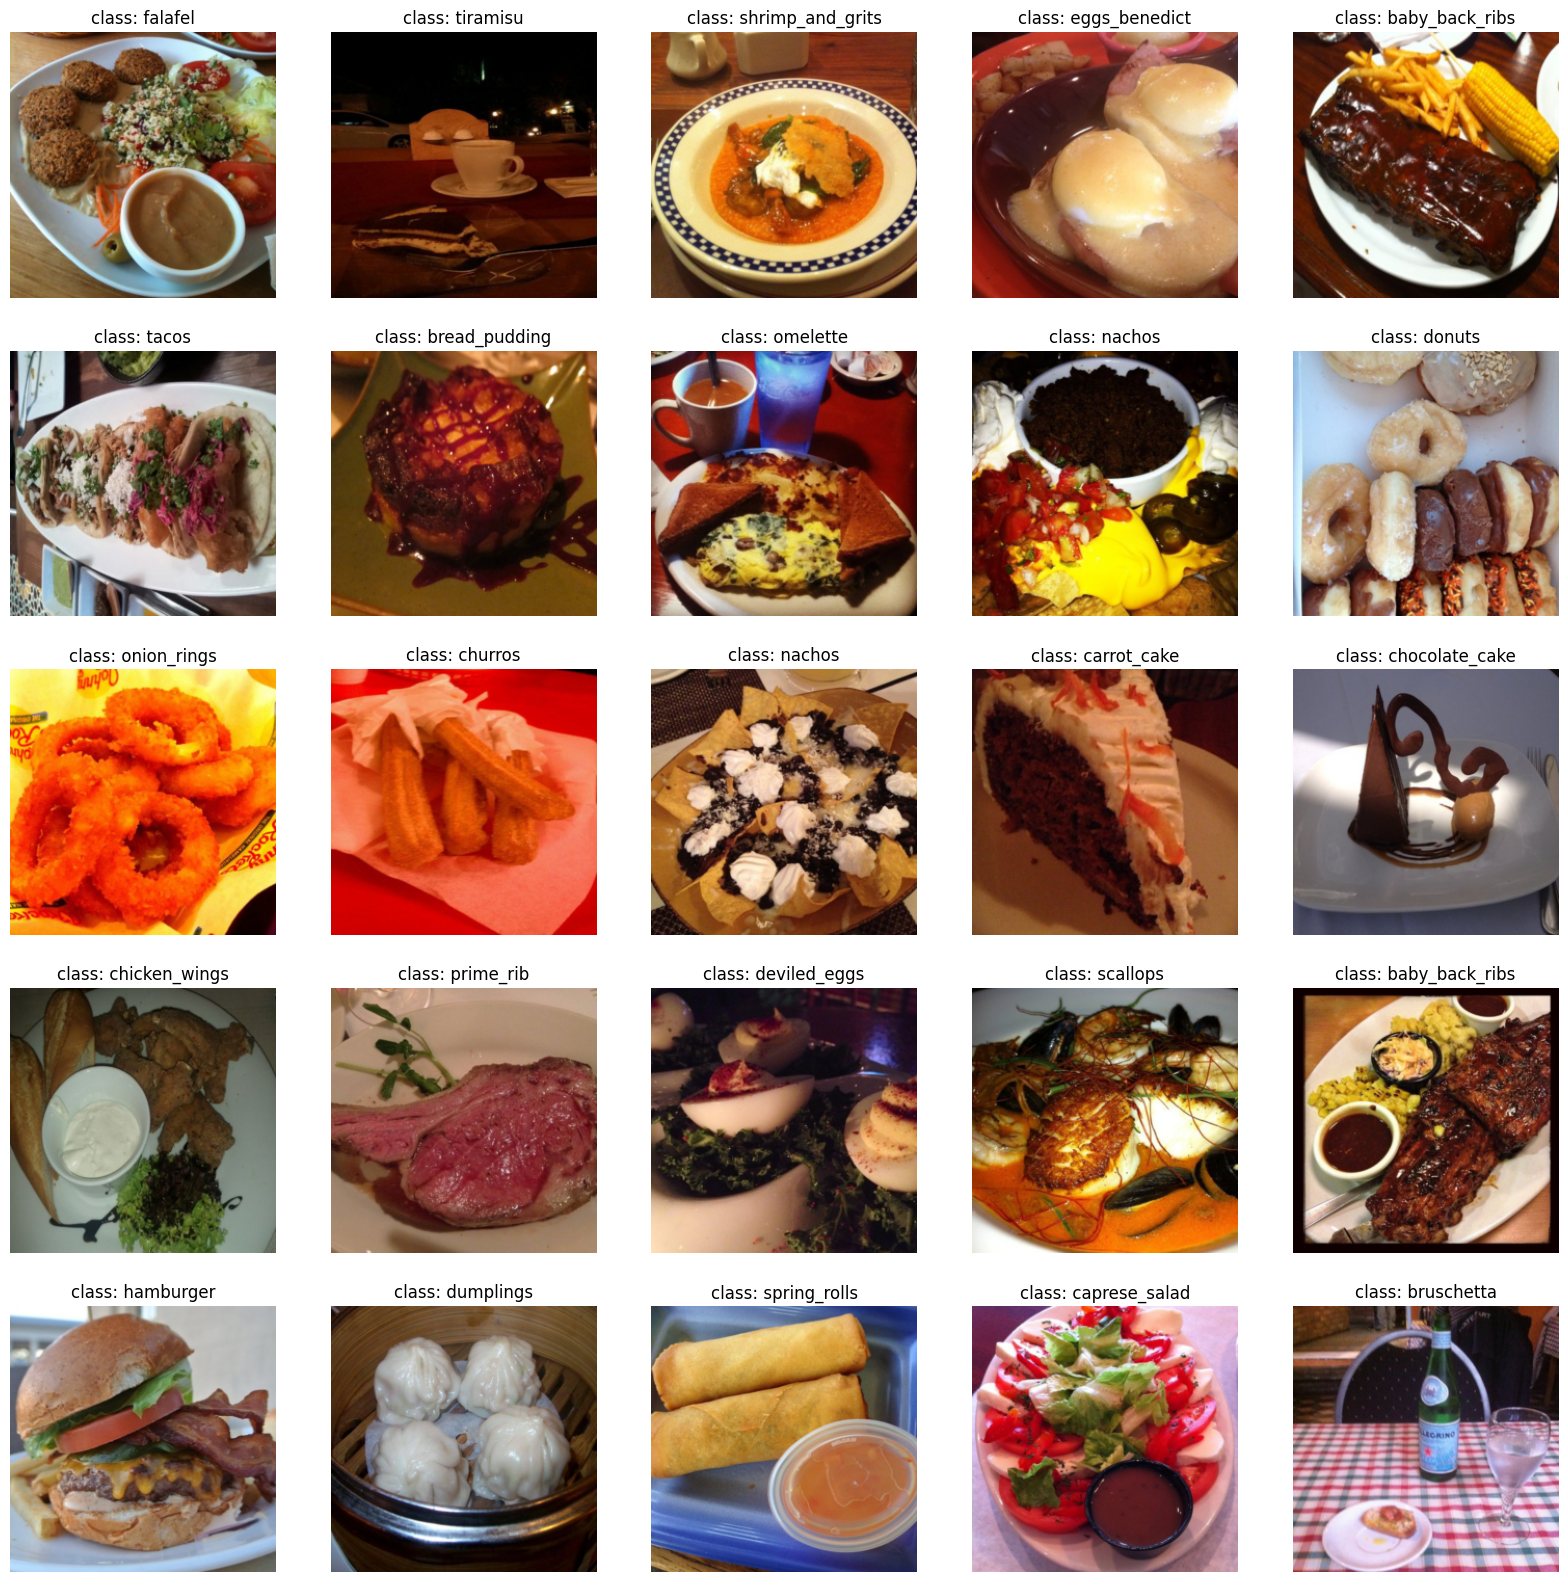

In [6]:
# Display images
manual_transforms = v2.Compose([
    v2.Resize((256, 256)),
    v2.RandomCrop((256, 256)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

train_data = datasets.ImageFolder(TRAIN_DIR, transform=manual_transforms)
display_random_images(train_data,
                      n=25,
                      classes=train_data.classes,
                      rows=5,
                      cols=5,
                      display_shape=False,
                      seed=None)

# 5. Default PyTorch's Swin Small Transformer

In [7]:
# Create transforms
IMG_SIZE_1 = 232
IMG_SIZE_2 = 224
manual_transforms_train = v2.Compose([    
    v2.TrivialAugmentWide(),
    v2.Resize((IMG_SIZE_1, IMG_SIZE_1)),
    v2.RandomCrop((IMG_SIZE_2, IMG_SIZE_2)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
    ])

manual_transforms_test = v2.Compose([    
    v2.Resize((IMG_SIZE_1, IMG_SIZE_1)),
    v2.CenterCrop((IMG_SIZE_2, IMG_SIZE_2)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
    ])

# Create dataloaders
BATCH_SIZE = 64
train_dataloader, test_dataloader, class_names = create_dataloaders(    
    train_dir=TRAIN_DIR,
    test_dir=TEST_DIR,
    train_transform=manual_transforms_train,
    test_transform=manual_transforms_test,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

# Copy weights from torchvision.models
set_seeds(SEED)

# Instantiate the model
model = torchvision.models.convnext_base(
    weights=torchvision.models.ConvNeXt_Base_Weights.DEFAULT,
    )

model.classifier[2] = nn.Linear(in_features=1024, out_features=len(class_names)).to(device)

# Compile model
model = torch.compile(model, backend="aot_eager")

# Print summary
#summary(model,
#        input_size=(BATCH_SIZE,3,IMG_SIZE_2, IMG_SIZE_2), # try swapping this for "random_input_image_error"
#        col_names=["input_size", "output_size", "num_params", "trainable"],
#        col_width=20,
#        row_settings=["var_names"])

c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


Epoch: 10 | train_loss: 0.9230 | train_acc: 0.9645 | fpr_at_recall: 0.0003 | train_time: 6m54s | test_loss: 1.0905 | test_acc: 0.9122 | fpr_at_recall: 0.0032 | test_time: 1m31s | lr: 0.0000034227


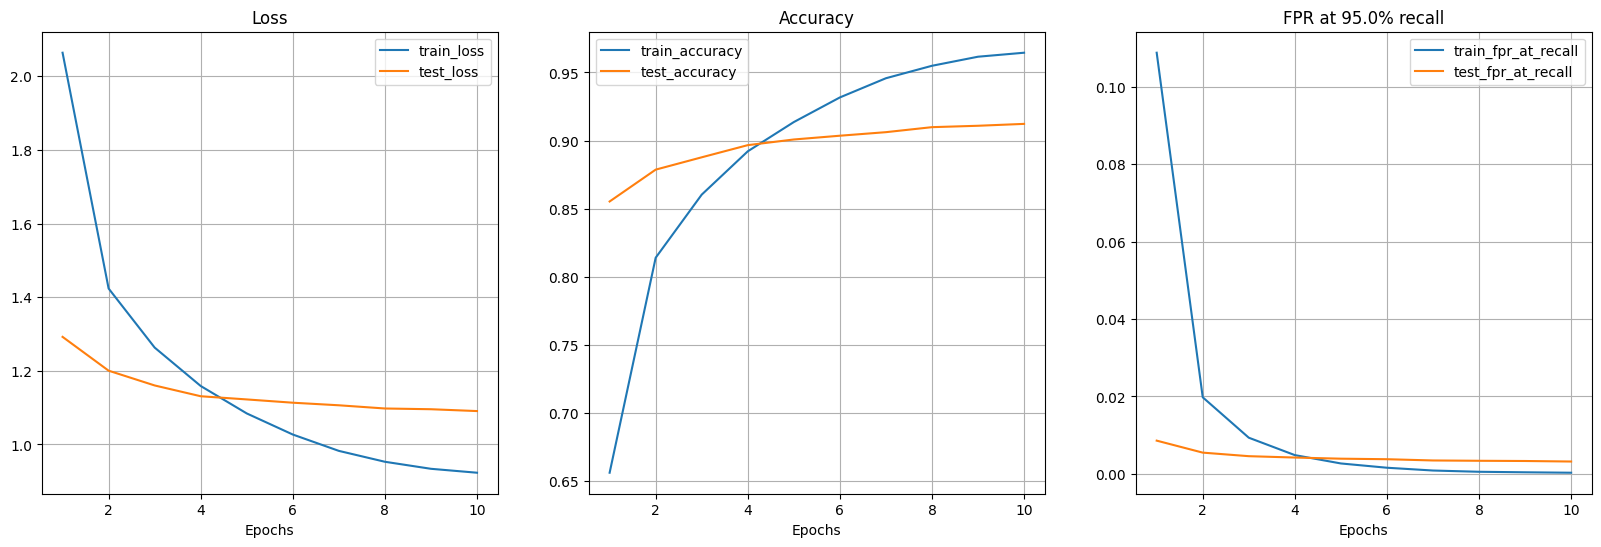

[INFO] Saving model to: ..\models\convb_101_2025-01-18_loss.pth
[INFO] Saving model to: ..\models\convb_101_2025-01-18_acc.pth
[INFO] Saving model to: ..\models\convb_101_2025-01-18.pth


In [5]:
# Train the model
model_type="convb_101_2025-01-18"
EPOCHS = 10
LR = 0.0001
model_name = f"{model_type}"
model_name = model_name + ".pth"

# Create optimizer
optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    weight_decay=0.01
)

# Create loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Set scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Set seeds
set_seeds(SEED)

# And train...
train = Trainer(
    model=model,
    save_best_model=True,
    mode=["loss", "acc"], # Based on accuracy
    device=device)

convb_results = train.fit(
    target_dir=MODEL_DIR,
    model_name=model_name,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    recall_threshold=0.95,
    scheduler=scheduler,
    epochs=EPOCHS,
    amp=True,
    enable_clipping=False,
    debug_mode=False,
    accumulation_steps=1,
    )

In [ ]:
convb_results

epoch  train_loss  train_acc  train_fpr_at_recall  train_time [s]  \
0      1    2.063947   0.655870             0.108768      503.660215   
1      2    1.423401   0.813871             0.019776      413.663595   
2      3    1.262969   0.860245             0.009337      414.336304   
3      4    1.158610   0.892062             0.004841      414.350217   
4      5    1.084097   0.913565             0.002685      409.474009   
5      6    1.026785   0.931662             0.001581      412.661222   
6      7    0.982375   0.945774             0.000861      418.544199   
7      8    0.952795   0.954924             0.000537      419.965293   
8      9    0.933696   0.961588             0.000404      421.505487   
9     10    0.923047   0.964522             0.000293      414.334887   

   test_loss  test_acc  test_fpr_at_recall  test_time [s]        lr  
0   1.292083  0.855201            0.008581     106.229631  0.000100  
1   1.200227  0.878604            0.005483      92.537071  0.000098  
2   1.160094  0.887668            0.004564      91.353017  0.000091  
3   1.130787  0.896603            0.004213      91.751184  0.000080  
4   1.122138  0.900761            0.003917      91.418605  0.000066  
5   1.113242  0.903530            0.003781      90.307624  0.000051  
6   1.106238  0.906136            0.003457      93.680854  0.000035  
7   1.097524  0.909819            0.003377      95.822545  0.000021  
8   1.095514  0.910843            0.003321      93.646651  0.000010  
9   1.090519  0.912228            0.003185      91.413891  0.000003

In [3]:
results = pd.read_csv(os.path.join(MODEL_DIR, "convb_101_2025-01-18.csv"))
training_time = sec_to_min_sec(results["train_time [s]"].mean() + results["test_time [s]"].mean())
print(f"training time: {training_time}")

training time: 8m38s


Epoch: 20 | train_loss: 0.8523 | train_acc: 0.9823 | fpr_at_recall: 0.0001 | train_time: 7m7s | test_loss: 1.1046 | test_acc: 0.9134 | fpr_at_recall: 0.0038 | test_time: 1m36s | lr: 0.0000016094


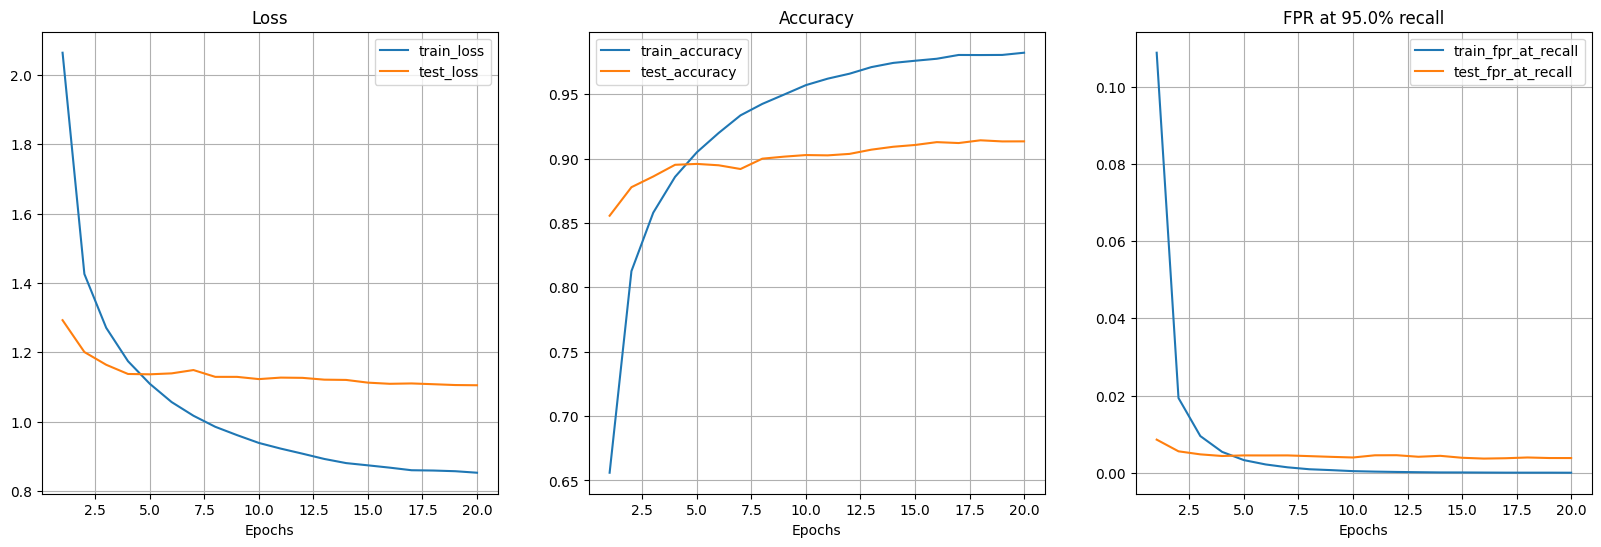

[INFO] Saving model to: ..\models\convb_101_2025-01-19_loss.pth
[INFO] Saving model to: ..\models\convb_101_2025-01-19.pth


In [8]:
# Train the model
model_type="convb_101_2025-01-19"
EPOCHS = 20
LR = 0.0001
model_name = f"{model_type}"
model_name = model_name + ".pth"

# Create optimizer
optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    weight_decay=0.01
)

# Create loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Set scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Set seeds
set_seeds(SEED)

# And train...
train = Trainer(
    model=model,
    save_best_model=True,
    mode=["loss", "acc"], # Based on accuracy
    device=device)

results = train.fit(
    target_dir=MODEL_DIR,
    model_name=model_name,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    recall_threshold=0.95,
    scheduler=scheduler,
    epochs=EPOCHS,
    amp=True,
    enable_clipping=False,
    debug_mode=False,
    accumulation_steps=1,
    )

In [9]:
results

epoch  train_loss  train_acc  train_fpr_at_recall  train_time [s]  \
0       1    2.063790   0.655962             0.108763      456.849815   
1       2    1.425551   0.812591             0.019386      408.471526   
2       3    1.270370   0.858014             0.009543      422.513597   
3       4    1.174009   0.885833             0.005447      419.863291   
4       5    1.108809   0.904944             0.003313      417.389004   
5       6    1.056096   0.919943             0.002187      420.984950   
6       7    1.016720   0.933624             0.001450      421.518634   
7       8    0.984825   0.942528             0.000950      422.892975   
8       9    0.960763   0.949790             0.000723      418.099677   
9      10    0.938219   0.957128             0.000462      418.752377   
10     11    0.921908   0.962143             0.000337      422.713346   
11     12    0.907243   0.966000             0.000252      419.444784   
12     13    0.892040   0.971112             0.000183      421.687550   
13     14    0.880099   0.974376             0.000127      429.825436   
14     15    0.873636   0.976052             0.000119      425.615957   
15     16    0.866944   0.977605             0.000092      429.234979   
16     17    0.859501   0.980548             0.000070      423.787879   
17     18    0.858632   0.980482             0.000067      432.119909   
18     19    0.856693   0.980574             0.000066      432.681676   
19     20    0.852335   0.982290             0.000051      427.637897   

    test_loss  test_acc  test_fpr_at_recall  test_time [s]        lr  
0    1.292304  0.855636            0.008616     103.978417  0.000100  
1    1.200433  0.877809            0.005592      92.579068  0.000099  
2    1.163709  0.886125            0.004804      92.152633  0.000098  
3    1.137165  0.895214            0.004381      92.828796  0.000095  
4    1.136205  0.895900            0.004532      91.835324  0.000091  
5    1.138891  0.894832            0.004522      91.545054  0.000086  
6    1.148486  0.891935            0.004532      92.590243  0.000080  
7    1.128837  0.899970            0.004347      92.410460  0.000073  
8    1.128808  0.901547            0.004160      92.064770  0.000066  
9    1.122376  0.902778            0.003993      92.100506  0.000058  
10   1.126681  0.902536            0.004562      95.001904  0.000051  
11   1.125961  0.903688            0.004583      91.953720  0.000043  
12   1.120769  0.906971            0.004181      92.310764  0.000035  
13   1.119989  0.909221            0.004426      96.972077  0.000028  
14   1.112157  0.910606            0.003921      94.172190  0.000021  
15   1.108823  0.912821            0.003710      94.087484  0.000015  
16   1.109864  0.912114            0.003802      92.339753  0.000010  
17   1.107626  0.914250            0.003996      94.456389  0.000006  
18   1.105242  0.913375            0.003854      94.603628  0.000003  
19   1.104616  0.913419            0.003848      96.517452  0.000002

In [10]:
results = pd.read_csv(os.path.join(MODEL_DIR, "convb_101_2025-01-19.csv"))
training_time = sec_to_min_sec(results["train_time [s]"].mean() + results["test_time [s]"].mean())
print(f"training time: {training_time}")

training time: 8m38s
